In [13]:
%load_ext tensorboard

import tensorflow as tf
import keras
from keras import layers
import yaml, datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [14]:
batch_size = 8
img_height = 256
img_width = 256

with open('config.yml', 'r') as file:
    paths = yaml.safe_load(file)

data_dir = paths['paths']['categories_path']

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Found 5166 files belonging to 7 classes.
Using 4133 files for training.
Found 5166 files belonging to 7 classes.
Using 1033 files for validation.


2024-01-04 23:57:33.589741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4133]
	 [[{{node Placeholder/_4}}]]
2024-01-04 23:57:33.591828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4133]
	 [[{{node Placeholder/_0}}]]


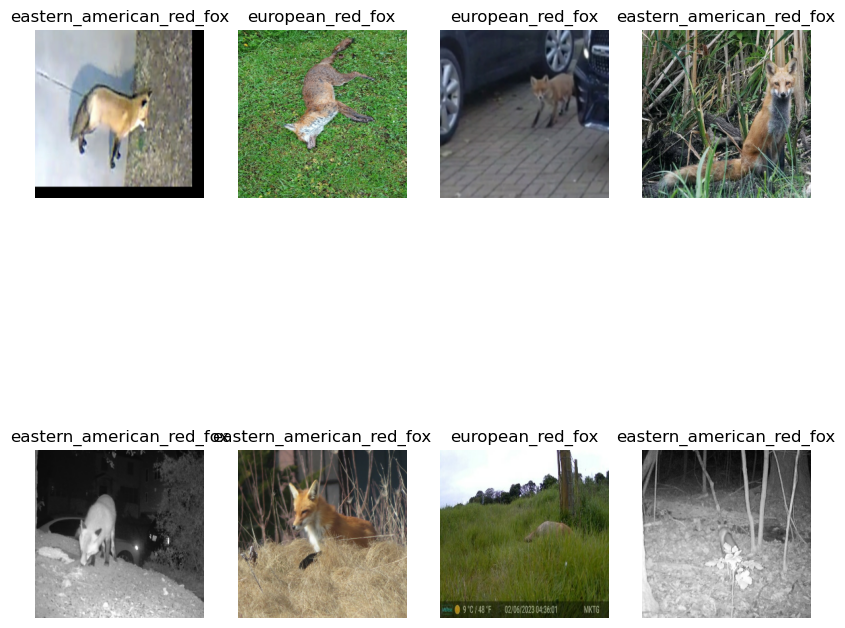

In [17]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [18]:
data_augmentation = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)

input = keras.Input(shape=(256, 256, 3))
x = data_augmentation(input)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu')(x)
x = layers.Flatten()(x)
output = layers.Dense(7, activation='softmax')(x)
model = keras.Model(inputs=input, outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                           

In [19]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_ds, 
                    epochs=30, 
                    validation_data=val_ds, 
                    callbacks=[tensorboard_callback])

Epoch 1/30


2024-01-04 23:58:00.923941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4133]
	 [[{{node Placeholder/_4}}]]
2024-01-04 23:58:00.925243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4133]
	 [[{{node Placeholder/_4}}]]


 96/517 [====>.........................] - ETA: 12s - loss: 1.8386 - accuracy: 0.2591

2024-01-04 23:58:06.096070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - ETA: 0s - loss: 1.7390 - accuracy: 0.2857

2024-01-04 23:58:18.248117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1033]
	 [[{{node Placeholder/_0}}]]
2024-01-04 23:58:18.249303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1033]
	 [[{{node Placeholder/_4}}]]


517/517 [==============================] - 19s 32ms/step - loss: 1.7390 - accuracy: 0.2857 - val_loss: 1.7551 - val_accuracy: 0.3507
Epoch 2/30
 97/517 [====>.........................] - ETA: 12s - loss: 1.7068 - accuracy: 0.3363

2024-01-04 23:58:23.090223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 16s 30ms/step - loss: 1.6721 - accuracy: 0.3419 - val_loss: 1.6124 - val_accuracy: 0.3826
Epoch 3/30
 96/517 [====>.........................] - ETA: 11s - loss: 1.6550 - accuracy: 0.3451

2024-01-04 23:58:38.722115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 16s 31ms/step - loss: 1.6362 - accuracy: 0.3530 - val_loss: 1.5346 - val_accuracy: 0.3826
Epoch 4/30
 95/517 [====>.........................] - ETA: 12s - loss: 1.6746 - accuracy: 0.3579

2024-01-04 23:58:59.507216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 16s 30ms/step - loss: 1.6055 - accuracy: 0.3818 - val_loss: 1.5428 - val_accuracy: 0.3681
Epoch 5/30
 97/517 [====>.........................] - ETA: 10s - loss: 1.5459 - accuracy: 0.3750

2024-01-04 23:59:14.795609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 16s 32ms/step - loss: 1.5530 - accuracy: 0.3859 - val_loss: 1.5035 - val_accuracy: 0.3681
Epoch 6/30
 95/517 [====>.........................] - ETA: 11s - loss: 1.5239 - accuracy: 0.4066

2024-01-04 23:59:31.473452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 17s 33ms/step - loss: 1.5377 - accuracy: 0.4048 - val_loss: 1.6103 - val_accuracy: 0.4290
Epoch 7/30
 94/517 [====>.........................] - ETA: 13s - loss: 1.5248 - accuracy: 0.4189

2024-01-04 23:59:48.960148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 17s 32ms/step - loss: 1.5299 - accuracy: 0.4104 - val_loss: 1.6966 - val_accuracy: 0.3884
Epoch 8/30
 95/517 [====>.........................] - ETA: 12s - loss: 1.4814 - accuracy: 0.4171

2024-01-05 00:00:05.490278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 17s 33ms/step - loss: 1.5062 - accuracy: 0.4179 - val_loss: 1.5031 - val_accuracy: 0.4174
Epoch 9/30
 96/517 [====>.........................] - ETA: 11s - loss: 1.5057 - accuracy: 0.3997

2024-01-05 00:00:22.321751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 16s 31ms/step - loss: 1.5084 - accuracy: 0.4212 - val_loss: 1.4964 - val_accuracy: 0.4203
Epoch 10/30
 97/517 [====>.........................] - ETA: 12s - loss: 1.4568 - accuracy: 0.4201

2024-01-05 00:00:38.840960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 17s 33ms/step - loss: 1.5039 - accuracy: 0.4232 - val_loss: 1.4405 - val_accuracy: 0.4841
Epoch 11/30
 95/517 [====>.........................] - ETA: 12s - loss: 1.4486 - accuracy: 0.4250

2024-01-05 00:00:55.696362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 17s 32ms/step - loss: 1.4912 - accuracy: 0.4268 - val_loss: 1.5235 - val_accuracy: 0.4203
Epoch 12/30
 95/517 [====>.........................] - ETA: 13s - loss: 1.4139 - accuracy: 0.4487

2024-01-05 00:01:12.623746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 18s 34ms/step - loss: 1.4719 - accuracy: 0.4309 - val_loss: 1.6824 - val_accuracy: 0.4000
Epoch 13/30
 97/517 [====>.........................] - ETA: 11s - loss: 1.4449 - accuracy: 0.4433

2024-01-05 00:01:30.187467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 17s 33ms/step - loss: 1.4825 - accuracy: 0.4384 - val_loss: 1.4151 - val_accuracy: 0.4696
Epoch 14/30
 95/517 [====>.........................] - ETA: 12s - loss: 1.4245 - accuracy: 0.4513

2024-01-05 00:01:47.514810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 18s 34ms/step - loss: 1.4740 - accuracy: 0.4411 - val_loss: 1.5792 - val_accuracy: 0.4319
Epoch 15/30
 95/517 [====>.........................] - ETA: 13s - loss: 1.4087 - accuracy: 0.4289

2024-01-05 00:02:05.275018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 18s 35ms/step - loss: 1.4678 - accuracy: 0.4423 - val_loss: 1.5469 - val_accuracy: 0.4377
Epoch 16/30
 96/517 [====>.........................] - ETA: 13s - loss: 1.4702 - accuracy: 0.4375

2024-01-05 00:02:23.506318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 18s 34ms/step - loss: 1.4646 - accuracy: 0.4452 - val_loss: 1.3714 - val_accuracy: 0.4754
Epoch 17/30
 96/517 [====>.........................] - ETA: 12s - loss: 1.4189 - accuracy: 0.4661

2024-01-05 00:02:41.160711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 18s 35ms/step - loss: 1.4670 - accuracy: 0.4481 - val_loss: 1.4987 - val_accuracy: 0.4522
Epoch 18/30
 95/517 [====>.........................] - ETA: 12s - loss: 1.4187 - accuracy: 0.4566

2024-01-05 00:03:01.714381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 18s 34ms/step - loss: 1.4598 - accuracy: 0.4430 - val_loss: 1.4526 - val_accuracy: 0.4551
Epoch 19/30
 95/517 [====>.........................] - ETA: 12s - loss: 1.4341 - accuracy: 0.4605

2024-01-05 00:03:19.642448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 18s 34ms/step - loss: 1.4667 - accuracy: 0.4498 - val_loss: 1.4071 - val_accuracy: 0.4493
Epoch 20/30
 96/517 [====>.........................] - ETA: 12s - loss: 1.4286 - accuracy: 0.4622

2024-01-05 00:03:37.439672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 18s 35ms/step - loss: 1.4866 - accuracy: 0.4508 - val_loss: 3.6322 - val_accuracy: 0.3884
Epoch 21/30
 96/517 [====>.........................] - ETA: 12s - loss: 1.4142 - accuracy: 0.4583

2024-01-05 00:03:55.816788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 18s 35ms/step - loss: 1.4542 - accuracy: 0.4573 - val_loss: 1.6696 - val_accuracy: 0.3884
Epoch 22/30
 96/517 [====>.........................] - ETA: 12s - loss: 1.4258 - accuracy: 0.4336

2024-01-05 00:04:16.272275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 19s 36ms/step - loss: 1.4657 - accuracy: 0.4437 - val_loss: 1.5613 - val_accuracy: 0.4638
Epoch 23/30
 95/517 [====>.........................] - ETA: 12s - loss: 1.3905 - accuracy: 0.4355

2024-01-05 00:04:34.643983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 18s 35ms/step - loss: 1.4571 - accuracy: 0.4447 - val_loss: 1.5078 - val_accuracy: 0.4261
Epoch 24/30
 96/517 [====>.........................] - ETA: 13s - loss: 1.4135 - accuracy: 0.4284

2024-01-05 00:04:52.995023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 19s 36ms/step - loss: 1.4748 - accuracy: 0.4350 - val_loss: 1.5654 - val_accuracy: 0.4493
Epoch 25/30
 95/517 [====>.........................] - ETA: 13s - loss: 1.4170 - accuracy: 0.4737

2024-01-05 00:05:11.964512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 19s 36ms/step - loss: 1.4729 - accuracy: 0.4457 - val_loss: 1.4995 - val_accuracy: 0.4348
Epoch 26/30
 95/517 [====>.........................] - ETA: 12s - loss: 1.4186 - accuracy: 0.4684

2024-01-05 00:05:30.261799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 18s 35ms/step - loss: 1.4642 - accuracy: 0.4541 - val_loss: 1.6307 - val_accuracy: 0.4261
Epoch 27/30
 95/517 [====>.........................] - ETA: 12s - loss: 1.4151 - accuracy: 0.4342

2024-01-05 00:05:48.398617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 19s 36ms/step - loss: 1.4719 - accuracy: 0.4333 - val_loss: 1.8719 - val_accuracy: 0.4203
Epoch 28/30
 96/517 [====>.........................] - ETA: 13s - loss: 1.4544 - accuracy: 0.4596

2024-01-05 00:06:07.358128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 19s 37ms/step - loss: 1.4758 - accuracy: 0.4592 - val_loss: 1.6070 - val_accuracy: 0.4580
Epoch 29/30
 96/517 [====>.........................] - ETA: 12s - loss: 1.3882 - accuracy: 0.4583

2024-01-05 00:06:26.381140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 19s 36ms/step - loss: 1.4819 - accuracy: 0.4503 - val_loss: 1.9175 - val_accuracy: 0.4116
Epoch 30/30
 95/517 [====>.........................] - ETA: 14s - loss: 1.4039 - accuracy: 0.4539

2024-01-05 00:06:45.603505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


517/517 [==============================] - 19s 36ms/step - loss: 1.4771 - accuracy: 0.4483 - val_loss: 1.9456 - val_accuracy: 0.3826


In [20]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 16925), started -1 day, 23:14:58 ago. (Use '!kill 16925' to kill it.)

2024-01-05 00:08:15.918716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1033]
	 [[{{node Placeholder/_4}}]]
2024-01-05 00:08:15.920271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1033]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 184ms/step


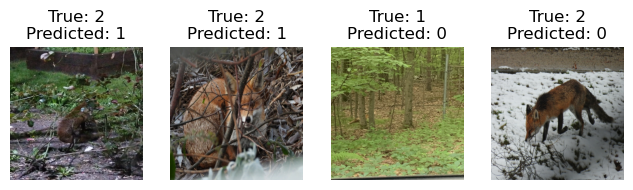

In [21]:
for images, labels in val_ds.take(1):
    labels = labels.numpy()
    predictions = [tf.argmax(i).numpy() for i in model.predict(images)]
    misclassified_indices = [i for i in range(len(predictions)) if predictions[i] != labels[i]]
    misclassified_images = [images[i] for i in misclassified_indices]

    plt.figure(figsize=(10, 10))
    for i in range(len(misclassified_images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(misclassified_images[i].numpy().astype("uint8"))
        plt.title(f"True: {labels[misclassified_indices[i]]}\nPredicted: {predictions[misclassified_indices[i]]}")
        plt.axis('off')

    plt.show()

In [22]:
model.evaluate(test_ds)

 1/86 [..............................] - ETA: 16s - loss: 1.9551 - accuracy: 0.3750

2024-01-05 00:08:29.769198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1033]
	 [[{{node Placeholder/_0}}]]
2024-01-05 00:08:29.771408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1033]
	 [[{{node Placeholder/_0}}]]


86/86 [==============================] - 1s 9ms/step - loss: 2.0097 - accuracy: 0.3808


[2.009655714035034, 0.38081395626068115]